# Non-linear equations: Part I

Show bisector, secant, and Newton methods for finding roots of non-linear equations with interactive [bokeh](http://bokeh.org/) plots.

- G. Brammer (21 September 2024)

**Notes for running the demo:** 

- Launch as slides with 

```bash
$ jupyter nbconvert --to slides week4-nonlinear-equations.ipynb --post serve --TemplateExporter.extra_template_basedirs=${PWD}/slide_templates/ --template revealx
```

- The interactive bokeh applets use pure-python callbacks.  For now this will only work with `jupyter` running locally and displaying to `localhost` in the browser.  The interactive bokeh plots do not work with cloud-hosted notebooks like [mybinder.org](mybinder.org) or [erda.dk](erda.dk).


In [1]:
try:
    from bokeh.themes import Theme
except ImportError:
    print('bokeh required!\nInstall it with\n$ pip install bokeh')

In [2]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 5]

from bokeh.themes import Theme
from bokeh.models.widgets.inputs import AutocompleteInput
from bokeh.models.widgets import (PreText, Div, Switch, Dropdown,
                                  RangeSlider, Slider, TextInput,
                                  MultiSelect, MultiChoice,
                                  RadioButtonGroup, Button,
                                  Toggle)

from bokeh.models import Range1d, Span

# from bokeh.models import Switch, Dropdown
from bokeh.layouts import column, row, layout
from bokeh.plotting import curdoc, figure, show

from bokeh.io import output_notebook

In [3]:
# %%javascript
# // Check if the jupyter port is something other than the default 8888
# var port = window.location.port;
# if (port != 8888) {
#     window.alert("In the next cell, use \n\nos.environ['BOKEH_ALLOW_WS_ORIGIN'] = 'localhost:" + port + "'\n")
# }

### Enable BokehJS server

Check the host address listed in the browser address bar above and add it in the comma-separated list below if the particular port is not already there.   This usually defaults to something like `localhost:8888/notebooks/week4-nonlinear-equations.ipynb`, but the port can be different, e.g., if you have multiple jupyter sessions running.  The entry needed below is the bit before `/notebooks/`, i.e., `localhost:8888`.

In [4]:
# If the previous cell raised a message, set the line below with the port as indicated
import os

os.environ['BOKEH_ALLOW_WS_ORIGIN'] = 'localhost:8888,localhost:8891,127.0.0.1:8000'

PORT = 8889
os.environ['BOKEH_ALLOW_WS_ORIGIN'] = f'localhost:{PORT}'
show_kws = dict(notebook_handle=True, notebook_url=f'localhost:{PORT}')

# Load this notebook as the bokeh server
output_notebook()

Loading BokehJS ...

In [5]:
# Function plotting range
x = np.linspace(-4,4, 1024)

# plot a function
def plot_func(func, deriv, title=None):
    plt.plot(x, func(x), label=r'$f(x)$')
    if deriv is not None:
        plt.plot(x, deriv(x), label=r"$f^\prime(x)$")
        
    plt.hlines(0, *plt.xlim(), color='g', linestyle='--', label=r'$y$=0')
    if title is not None:
        plt.title(title)
        
    plt.legend()
    plt.grid()

# Motivation

We want to find *roots* of non-linear equations $f(\mathbf{x}) = \mathbf{0}$.

- Linear equations ($A~\mathbf{x} = \mathbf{b}$) are easy (weeks 1+2)!

- On Wednesday we'll discuss how to find roots in *systems* of non-linear equations, but let's start today in 1D.

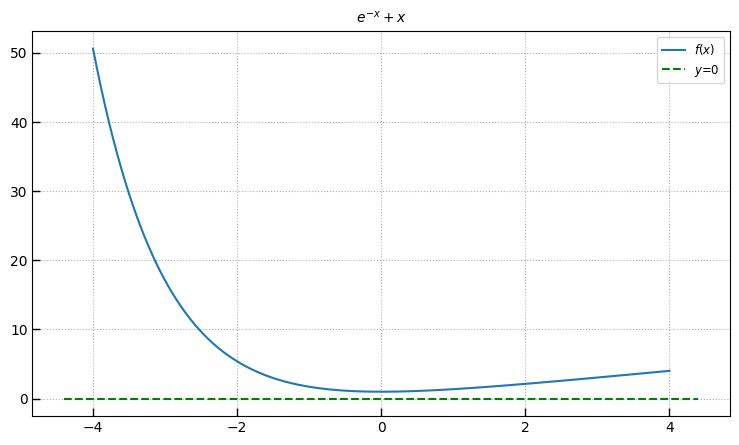

In [6]:
# Some example functions
fx = lambda x: np.exp(-x) + x
plot_func(fx, None, title=r'$e^{-x} + x$')

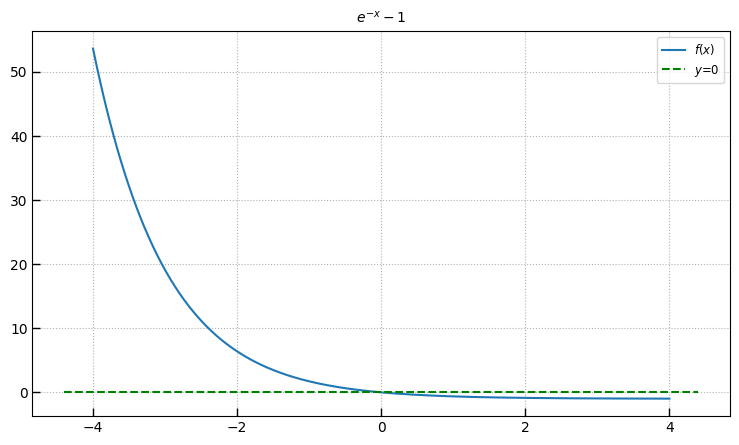

In [7]:
fx = lambda x: np.exp(-x) - 1 
plot_func(fx, None, title=r'$e^{-x} - 1$')

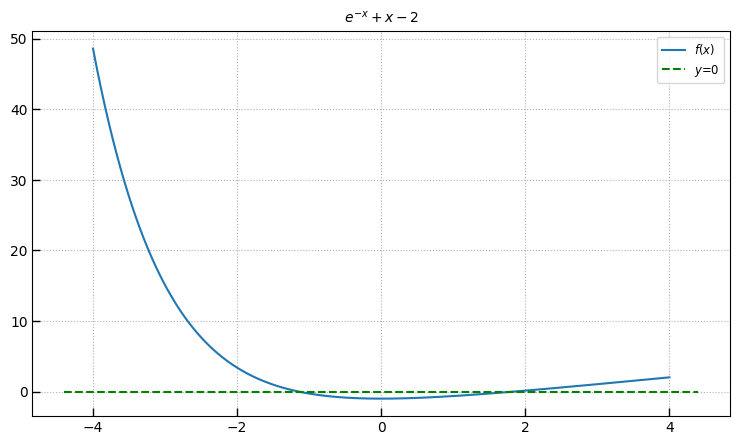

In [8]:
fx = lambda x: np.exp(-x) + x - 2
plot_func(fx, None, title=r'$e^{-x} + x - 2$')

# Finding roots in 1D

The *Intermediate Value Theorem* states:

> If $f$ is continuous in $[a,b]$ and $c$ is between $f(a)$ and $f(b)$, then there exists a value $x^* \in [a,b]$ such that $f(x^*) = c$.

So if $\mathrm{sign}(f(a)) \ne \mathrm{sign}(f(b))$, then there must be a root of $f$ in $[a,b]$.

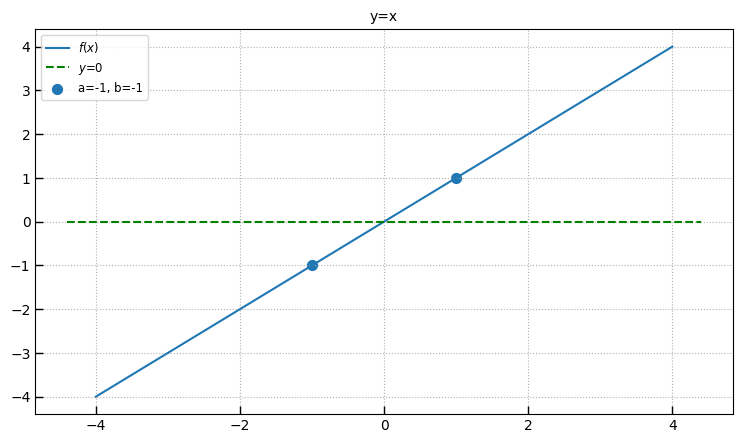

In [9]:
fx = lambda x: x
plot_func(fx, None, title=r'y=x')
plt.scatter([-1,1], [-1,1], label='a=-1, b=-1', s=200); _ = plt.legend()

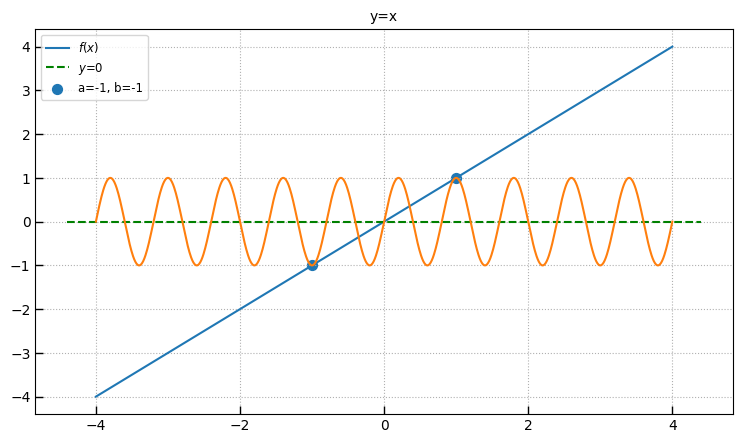

In [10]:
fx = lambda x: x
plot_func(fx, None, title=r'y=x')
plt.scatter([-1,1], [-1,1], label='a=-1, b=-1', s=200); _ = plt.legend()
_ = plt.plot(x, np.sin(x*np.pi*5./2))

## Uniqueness (of a root)

In 1D we only have the worry that a root may also be a minimum or a maximum.

So we have a **simple** root when $f(x) = 0 \wedge f^\prime(x) \ne 0$.

And we have a **multiple** root when $f(x) = 0 \wedge f^\prime(x) = 0$.

However, it's generally very difficult to generalize an answer to
> *How many (simple, multiple) roots are beteween $[a,b]$*?

# Sensitivity

How does the function behave around the root?
- Approaching rapidly
- Approaching extremely slowly

# Conditioning

We work with absolute conditioning numbers, since we're working with absolute numbers around $y=0$ at the root.  As with linear equations we have that $c = \frac{1}{| f^\prime(x^*) |}$.

If $| f^\prime(x^*) | \leq \epsilon$, then the error of $|\hat x - x^*|$ may be as large as $\frac{\epsilon}{| f^\prime(x^*) |}$.  

This means that in 1D a multiple root ($f^\prime(x) = 0$) has an *infinite* conditioning number - we are obviously very sensitive numerically at this point.

# Convergence rates

$e_k = x_k - x^*$

$\lim_{k \to \infty} \frac{|| e_{k+1} ||}{||e_k||^r} = C$ for some constant $C>0$.

($C < 1$)

- $r=1$: Linear convergence
- $r=2$: Quadratic convergence
- $1 < r < 2$: Superlinear convergence

**Example 5.1** from the book:

$f(x) = x^2 - 4 \sin(x)$

$f^\prime(x) = 2 x - 4 \cos(x)$


In [11]:
# Define with global variables to count function calls
FUNC_CALLS = 0
DERIV_CALLS = 0

a0, b0 = -3.01, 1.01

def myfunc(x):
    global FUNC_CALLS
    FUNC_CALLS += 1
    
    return np.array(x)**2 - 4*np.sin(x)

def myfunc_deriv(x):
    global DERIV_CALLS
    DERIV_CALLS += 1
    
    return 2*np.array(x) - 4*np.cos(x)

# Copies in case we change it later
orig_func = myfunc
orig_deriv = myfunc_deriv

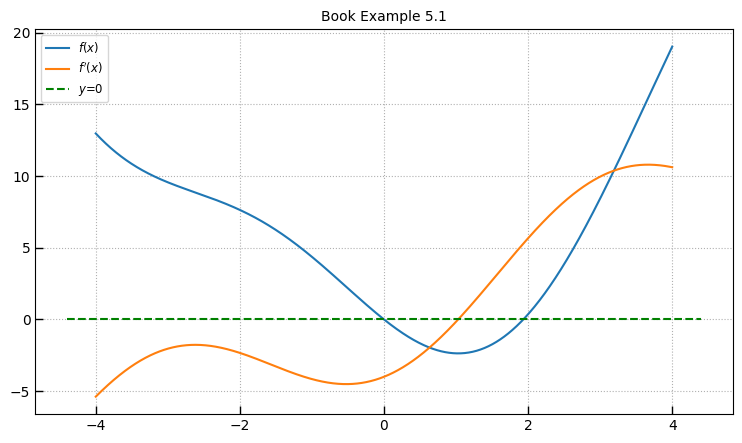

In [12]:
plot_func(myfunc, myfunc_deriv, title='Book Example 5.1')

# Find roots with the `bisection` algorithm

1. *"bracket the root"*: Find an interval $[a,b]$ where $\mathrm{sign}(f(a)) \ne \mathrm{sign}(f(b))$.
1. Evaluate $f$ at the midpoint $m$ between $[a,b]$.
1. If $\mathrm{sign}(f(m)) = \mathrm{sign}(f(a))$, then $a \rightarrow m$.
    - Else $b \rightarrow m$.
1. Repeat ...

### Convergence

$\lim_{k \to \infty} \frac{|| e_{k+1} ||}{||e_k||^r} = C$

$r=1$, $C=0.5$ : *linear* convergence.

The interval is reduced in half at each iteration, so after $k$ iterations the interval has width $(b-a)/2^k$.

So if achieving a tolerance $tol$ requires $k=\log_2 \left(\frac{b-a}{tol}\right)$ steps.

In [13]:
def bisection_root(func, a, b, n_steps=2, tol=None):
    """
    Do iterations of the bisection method to find roots
    """
    global FUNC_CALLS
    FUNC_CALLS = 0
    
    fa = func(a)
    fb = func(b)
    
    if np.sign(fa) == np.sign(fb):
        # need to have opposite sign before we begin
        raise ValueError(f'sign(f({a})) is the same as sign(f({b})) !')

    if tol is not None:
        n_steps = int(np.ceil(np.log2((b-a)/tol)))

    i = 0
    for i in range(n_steps):
        m = a + (b-a)/2. # equivalent to (a+b) / 2 but doesn't overflow
        fm = func(m)

        if np.sign(fm) == np.sign(fa):
            # f(m) and f(a) have same sign, new interval is [a=m, b]
            a, fa = m, fm
        else:
            # f(m) and f(a) have opposite sign, new interval is [a, b=m]
            b, fb = m, fm

    return a, b, i
            

In [14]:
# Test it
n = 5
ai, bi, i = bisection_root(myfunc, -1, 0.8, n_steps=5) # OK

print(f'n_steps: {n}, function calls: {FUNC_CALLS}')

n_steps: 5, function calls: 7


In [15]:
# breaks because signs are the same
ai, bi, i = bisection_root(myfunc, -1, 3, n_steps=5) # OK

ValueError: sign(f(-1)) is the same as sign(f(3)) !

In [16]:
for n in range(8):
    ai, bi, i = bisection_root(myfunc, a0, b0, n_steps=n)
    print(f'{n} {ai:.3f} {bi:.3f}')

0 -3.010 1.010
1 -1.000 1.010
2 -1.000 0.005
3 -0.498 0.005
4 -0.246 0.005
5 -0.121 0.005
6 -0.058 0.005
7 -0.026 0.005


In [17]:
# Make a bokeh "app" for interactive plotting    
# Awkward packagaging so that can use a pure-python callback
def bisect_app(doc):
    global myfunc
    
    def text_label(a, b):
        return f'a={a:8.4e} b={b:8.4e}  m={a + (b-a)/2.:8.4e}'

    fig = figure(title="bisection", width=800, height=500,
                 background_fill_color='white',
                 active_drag='box_zoom')
    
    fig.xaxis.axis_label = 'x'
    fig.yaxis.axis_label = 'y'
    fig.xaxis.axis_label_text_font_style = "normal"
    fig.yaxis.axis_label_text_font_style = "normal"

    data_line = fig.line(x=x, y=myfunc(x), color='black', alpha=0.5, line_width=2, legend_label='f(x)')
    init_scatter = fig.scatter([0,0], [0,0], size=10, color='black')
    # step_scatter = fig.scatter([0,0], [0,0], size=10, color='red', alpha=0.8)

    spans = fig.vspan(x=[0, 0], line_color='red', line_alpha=0.5, legend_label='a, b')
    yroot = fig.hspan(y=[0], line_color='green', line_alpha=0.3, legend_label='midpt')

    midp_vline = fig.vspan(x=[0], line_color='magenta', line_alpha=0.5)
    
    ITEM_HEIGHT = 64
    text_a = TextInput(title='a', value=f'{a0:.2f}', width=70, height=ITEM_HEIGHT)
    text_b = TextInput(title='b', value=f'{b0:.2f}', width=70, height=ITEM_HEIGHT)

    txt = Div(text=text_label(a0, b0), sizing_mode="fixed", width=450, height=ITEM_HEIGHT,
              styles={'font-size': '110%', 'font-family': 'monospace'})
    
    nsteps = Slider(start=0, end=20, value=0, step=1, 
                    title='n_steps', sizing_mode="fixed", width=200, height=ITEM_HEIGHT)
    
    def update_steps():
        """
        Perform n steps of the bisection algorithm and then plot the results
        """
        n_step = nsteps.value
        a0i = float(text_a.value)
        b0i = float(text_b.value)

        init_scatter.data_source.data = {'x': [a0i, b0i], 'y': myfunc([a0i, b0i])}

        ai, bi, i = bisection_root(myfunc, a0i, b0i, n_steps=n_step, tol=None)
        # step_scatter.data_source.data = {'x': [ai, bi], 'y': myfunc([ai, bi])}
        spans.data_source.data = {'x': [ai, bi]}
        
        m = ai + (bi-ai)/2        
        midp_vline.data_source.data = {'x': [m]}

        txt.text = text_label(ai, bi)

    update_steps()
    
    nsteps.on_change('value', lambda attr, old, new: update_steps())
    text_a.on_change('value', lambda attr, old, new: update_steps())
    text_b.on_change('value', lambda attr, old, new: update_steps())
    
    sliders = row(nsteps)
    p = layout([[text_a, text_b, sliders, txt],
                [fig]])

    doc.add_root(p)
    
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 600
                width: 900
            Grid:
                grid_line_dash: [2, 2]
                grid_line_color: lightgray
    """, Loader=yaml.FullLoader))


In [18]:
show(bisect_app, **show_kws)

# Fixed-point integration

$x_{k+1} = g(x_k)$

If $x^* = g(x^*)$ and $|g^\prime(x^*)| < 1$, then the iterative scheme is *locally convergent*.

In [19]:
def fixed_point(func, x0, n_steps=3):
    """
    Fixed point demo
    """
    xk = x0   
    for i in range(n_steps):
        xi = func(xk)
        xk = xi
        
    return xk, i

In [20]:
def fixed_point_trace(func, x0, n_steps=3):
    """
    keep track of the trace for plotting
    """
    xk = x0
    xtrace, ytrace = [xk, xk], [xk, xk]
    
    for i in range(n_steps):
        xi = func(xk)
        if np.abs(xi) > 1e5:
            break

        xtrace += [xk, xk]
        ytrace += [xk, xi]
        xk = xi
        
    return xk, xtrace, ytrace

In [21]:
x0 = 2.3
func1 = lambda x : x**2 - 2
func2 = lambda x : 1 + 2/x

xfixed = np.linspace(0.6, 5, 256)

# Make a bokeh "app" for interactive plotting    
def fixed_app(doc):
    global fixed_func
    
    def text_label(a, b):
        return f'a={a:8.4e} b={b:8.4e}  m={a + (b-a)/2.:8.4e}'

    fig = figure(title="fixed point", width=800, height=500,
                 background_fill_color='white',
                 active_drag='box_zoom')
    
    fig.xaxis.axis_label = 'x'
    fig.yaxis.axis_label = 'y'
    fig.xaxis.axis_label_text_font_style = "normal"
    fig.yaxis.axis_label_text_font_style = "normal"

    fig.x_range = Range1d(0.6, 3.4)
    fig.y_range = fig.x_range
    
    func1_line = fig.line(x=xfixed, y=func1(xfixed), color='red',
                         legend_label='func1',
                         alpha=0.3, line_width=4)
    func2_line = fig.line(x=xfixed, y=func2(xfixed), color='green',
                         legend_label='func2',
                         alpha=0.3, line_width=4)
    
    yx_line = fig.line(x=x, y=x, color='gray', legend_label = 'y = x',
                       alpha=0.5, line_width=2, line_dash='dotted')
    
    iter1_line = fig.line(x=[0], y=[0], color='red', alpha=0.8, line_width=2)
    iter2_line = fig.line(x=[0], y=[0], color='green', alpha=0.8, line_width=2)

    ITEM_HEIGHT = 64
    text_x0 = TextInput(title='x0', value=f'{x0:.2f}', width=70, height=ITEM_HEIGHT)

    nsteps = Slider(start=0, end=20, value=0, step=1, 
                    title='n_steps', sizing_mode="fixed", width=200, height=ITEM_HEIGHT)
    
    def update_steps():
        """
        Perform n steps of the bisection algorithm and then plot the results
        """
        n_step = nsteps.value
        x0i = float(text_x0.value)
        xk, xt, yt = fixed_point_trace(func1, x0i, n_steps=n_step)
        iter1_line.data_source.data = {'x': xt, 'y': yt}
        xk, xt, yt = fixed_point_trace(func2, x0i, n_steps=n_step)
        iter2_line.data_source.data = {'x': xt, 'y': yt}

    update_steps()
    
    nsteps.on_change('value', lambda attr, old, new: update_steps())
    text_x0.on_change('value', lambda attr, old, new: update_steps())
    
    sliders = row(nsteps)
    p = layout([[text_x0, sliders],
                [fig]])

    doc.add_root(p)
    
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 600
                width: 900
            Grid:
                grid_line_dash: [2, 2]
                grid_line_color: lightgray
    """, Loader=yaml.FullLoader))


In [22]:
func1 = lambda x : x**2/3 - (2**2/3 - 2) # two fixed points at x=1,2 g'(x) ~ 2/3, 4/3
func2 = lambda x : 1 + 2/x               # g'(2) = -1/2

show(fixed_app, **show_kws) # try x0=1.5

In [23]:
func1 = lambda x : (x-2)**2+2 # g'(2) = 0 - converges very rapidly
func2 = lambda x : 1 + 2/x    # g'(2) = -1/2

show(fixed_app, **show_kws) # try x0=1.5

# The `secant` algorithm

If analytical derivative isn't available, use $x$ and $f(x)$ to approximate it.

$x_{k+1} = x_k - f(x_k) (x_k - x_{k-1}) / (f(x_k) - f(x_{k-1}))$

**Convergence** is superlinear with $r \approx 1.618$.

<!-- Equivalently, to be a bit safer numerically if magnitudes of the components are very different:

$x_{k+1} = (~x_{k-1} f(x_k) - x_k f(x_{k-1})~)~/~(~f(x_k) - f(x_{k-1})~)$
 -->
 
<!-- xk - fk (xk - x1) / (fk - f1)
[ xk (fk - f1) - fk ( xk - x1 ) ] / (fk - f1)
[ xk fk - xk f1 - fk xk + fk x1 ] / (fk - f1) 
[ - (xk f1 + fk x1) / (fk - f1) -->

In [32]:
def secant_root(func, x0, x1, n_steps=2, tol=1e-30):
    """
    Do iterations of the secant method to find roots of `func`
    """

    xk = x1
    fk = func(xk)

    xkm = x0
    fkm = func(xkm)

    i = 0
    for i in range(n_steps):    
        # Optional test if change is already smaller than some specified tolerance
        dx = fk*(xk-xkm)/(fk-fkm)
        if tol is not None:
            if np.abs(dx) < tol:
                break
            
        xk1 = xk - dx

        # use previous function evaluation as k-1
        fkm = fk
        xkm = xk

        # Updated xk, fk > x_k+1, f(x_k+1)
        xk = xk1
        fk = func(xk1)        
        
    return xk, xkm, fk, fkm, i+1

In [33]:
xk, xkm, fk, fkm, i = secant_root(myfunc, a0, b0, n_steps=4)
print(f'secant: xk = {xk:.4e} after {i} steps')

secant: xk = 4.3885e-04 after 4 steps


In [34]:
def secant_app(doc):
    global myfunc
    
    def text_label(xk, xkm, fk, fkm):
        xp1 = xk - fk*(xk-xkm)/(fk-fkm)
        return f'x(k-1, k) = {xkm:7.4f}, {xk:7.4f} <br> -> x(k+1) = {xp1:9.4e}'

    fig = figure(title="secant method", width=800, height=500,
                 background_fill_color='white',
                 active_drag='box_zoom')
    
    fig.xaxis.axis_label = 'x'
    fig.yaxis.axis_label = 'y'
    fig.xaxis.axis_label_text_font_style = "normal"
    fig.yaxis.axis_label_text_font_style = "normal"

    ITEM_HEIGHT = 64

    text_x0 = TextInput(title='x0', value=f'{a0:.2f}', width=70, height=ITEM_HEIGHT)
    text_x1 = TextInput(title='x1', value=f'{b0:.2f}', width=70, height=ITEM_HEIGHT)

    data_line = fig.line(x=x, y=myfunc(x), color='black', alpha=0.5, line_width=2, legend_label='f(x)')
    initial_scatter = fig.scatter(np.array([a0, b0]), myfunc(np.array([a0, b0])), size=10, color='black')

    yroot = fig.hspan(y=[0], line_color='green', line_alpha=0.3)

    secant_scatter = fig.scatter([0,0], [0,0], size=10, color='red', legend_label='x(k), x(k-1)')
    secant_line = fig.line(x=[0,0], y=[0,0], color='red', alpha=1.0, line_width=2, legend_label='secant')

    xk_scatter = fig.scatter([0], [0], size=10, color='magenta', marker='+', legend_label='x(k+1)')
    xk_line = fig.line([0, 0], [0, 0], color='magenta', alpha=0.8)

    txt = Div(text=" ", sizing_mode="fixed", width=450, height=ITEM_HEIGHT,
              styles={'font-size': '110%', 'font-family': 'monospace'})
    
    nsteps = Slider(start=0, end=20, value=0, step=1, 
                    title='n_steps', sizing_mode="fixed", width=200, height=ITEM_HEIGHT)
    
    def update_steps():
        """
        Perform n steps of the bisection algorithm and then plot the results
        """
        n_step = nsteps.value
        x0i = float(text_x0.value)
        x1i = float(text_x1.value)

        initial_scatter.data_source.data = {'x': [x0i, x1i], 'y': myfunc([x0i, x1i])}

        xk, xkm, fk, fkm, i = secant_root(myfunc, x0i, x1i, n_steps=n_step, tol=None)
        secant_line.data_source.data = {'x': [xk, xkm], 'y':[fk, fkm]}
        secant_scatter.data_source.data = {'x': [xk, xkm], 'y': [fk, fkm]}

        # next k+1
        xp1 = xk - fk*(xk-xkm)/(fk-fkm)
        xk_scatter.data_source.data = {'x': [xp1], 'y': [0]}
        xk_line.data_source.data = {'x': [xk, xkm, xp1], 'y': [fk, fkm, 0]}

        txt.text = text_label(xk, xkm, fk, fkm)

    update_steps()
    
    nsteps.on_change('value', lambda attr, old, new: update_steps())
    text_x0.on_change('value', lambda attr, old, new: update_steps())
    text_x1.on_change('value', lambda attr, old, new: update_steps())

    sliders = row(nsteps)
    p = layout([[text_x0, text_x1, sliders, txt],
                [fig]])

    doc.add_root(p)
    
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 600
                width: 900
            Grid:
                grid_line_dash: [2, 2]
                grid_line_color: lightgray
    """, Loader=yaml.FullLoader))

In [35]:
myfunc = orig_func; myfunc_deriv = orig_deriv
show(secant_app,  notebook_handle=True, notebook_url='localhost:8889')

# `newton_raphson` method

Appromate $f(x)$ with a *linear* function $f(x + h) \approx f(x) + f^\prime(x)~h$.  This has a zero at $h=-f(x)/f^\prime(x)$.

So use a fixed-point scheme with 

$f(x) = 0 \rightarrow g(x) = x - f(x)/f^\prime(x)$. 

This function does not have the same exact fixed point as the root of $f(x)$, but the two converge with subsequent iterations as $x_k \rightarrow x^*$ with 

$g(x_k) = x_k - f(x_k \rightarrow x^*) / f^\prime(x_k) = x_k - 0/f^\prime(x_k) = x_k $.

<!-- **[There was a typo in class where I wrote the step update in the first definition of $g(x)$ as $-f^\prime(x)/f(x)$, it's fixed now]**
 -->
 
Uses function evaluations *and* analytical derivative

$x_{k+1} = x_k - f(x_k) / f^\prime(x_k)$


# `newton_raphson` method

**Convergence** is quadratic ($r=2$) for simple roots but linear for multiple roots with $C=1-(1/m)$.  For $m > 2$, $ 0.5 < C < 1$ and this becomes slower than the bisector method with $C=0.5$!

In [36]:
def newton_root(func, func_deriv, x0, n_steps=3, tol=1.e-20):
    """
    Newton(-Raphson) iteration for root-finding
    """
    xk = x0
    xkm = xk

    if n_steps == 0:
        # calculate function and deriv to have something to return if n=0
        fk = func(xk)
        dfk = func_deriv(xk)
        xk = xk - fk/dfk

        i = 0
        
    for i in range(n_steps):        
        # Save x(k-1)
        xkm = xk

        # Update 
        fk = func(xk)
        dfk = func_deriv(xk)
        h = fk/dfk
        if tol is not None:
            if np.abs(h) < tol:
                break
            
        xk = xk - fk/dfk

    return xkm, xk, fk, dfk, i+1

In [37]:
xkm, xk, _, _, i = newton_root(myfunc, myfunc_deriv, a0, n_steps=3)
print(f'Newton: xk = {xk:.4e} after {i} steps')

Newton: xk = 1.9358e+00 after 3 steps


In [38]:
def newton_app(doc):

    global myfunc, myfunc_deriv
    
    def text_label(xk, xkm):
        return f'x(k) {xkm:9.4e} -> x(k+1) = {xk:9.4e}'
    
    fig = figure(title="newton method", width=800, height=500,
                 background_fill_color='white',
                 active_drag='box_zoom')
    
    fig.xaxis.axis_label = 'x'
    fig.yaxis.axis_label = 'y'
    fig.xaxis.axis_label_text_font_style = "normal"
    fig.yaxis.axis_label_text_font_style = "normal"

    ITEM_HEIGHT = 64

    text_x0 = TextInput(title='x0', value=f'{a0:.2f}', width=70, height=ITEM_HEIGHT)

    data_line = fig.line(x=x, y=myfunc(x), color='black', alpha=0.5, line_width=2, legend_label='f(x)')
    initial_scatter = fig.scatter(np.array([a0]), myfunc(np.array([a0])), size=10, color='black')

    yroot = fig.hspan(y=[0], line_color='green', line_alpha=0.3)

    xk_scatter = fig.scatter([0], [0], size=10, color='magenta', marker='o', legend_label='x(k)')
    xk_line = fig.line([0, 0], [0, 0], color='magenta', alpha=0.8)
    xk1_scatter = fig.scatter([0], [0], size=10, color='magenta', marker='x', legend_label='x(k+1)')

    txt = Div(text=" ", sizing_mode="fixed", width=500, height=ITEM_HEIGHT,
              styles={'font-size': '110%', 'font-family': 'monospace'})
    
    nsteps = Slider(start=0, end=20, value=0, step=1, 
                    title='n_steps, k=', sizing_mode="fixed", width=200, height=ITEM_HEIGHT)
    
    def update_steps():
        """
        Perform n steps of the bisection algorithm and then plot the results
        """
        n_step = nsteps.value + 1
        x0i = float(text_x0.value)

        initial_scatter.data_source.data = {'x': [x0i], 'y': myfunc([x0i])}

        xkm, xk, fk, dfk, i = newton_root(myfunc, myfunc_deriv, x0i, n_steps=n_step)

        # next k+1
        xp1 = xk - fk*(xk-xkm)/(fk-fkm)
        xk_scatter.data_source.data = {'x': [xkm], 'y': [fk]}
        xk1_scatter.data_source.data = {'x': [xk], 'y': [myfunc(xk)]}
        xk_line.data_source.data = {'x': [xkm, xk], 'y': [fk, 0]}

        txt.text = text_label(xk, xkm)

    update_steps()
    
    nsteps.on_change('value', lambda attr, old, new: update_steps())
    text_x0.on_change('value', lambda attr, old, new: update_steps())

    sliders = row(nsteps)
    p = layout([[text_x0, sliders, txt],
                [fig]])

    doc.add_root(p)
    
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 600
                width: 900
            Grid:
                grid_line_dash: [2, 2]
                grid_line_color: lightgray
    """, Loader=yaml.FullLoader))


In [39]:
# Newton algorithm
# also try x0 = -1.6, -1.7, -1.8078324
show(newton_app, notebook_handle=True, notebook_url='localhost:8889')

In [ ]:
myfunc = orig_func; myfunc_deriv = orig_deriv
show(secant_app,  notebook_handle=True, notebook_url='localhost:8889')

# `inverse_quadratic` algorithm

Approximate $x = f(x)$ as a parabola.

Fit inverse parabolas to three function samples $f(x)$ at $x = (a, b, c)$.

No analytic derivative needed.

**Convergence** is superlinear $r \approx 1.839$.

The "Brent" ([scipy.optimize.brent](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brent.html)) algorithm is a combination of the safe-but-linear `bisection` algorithm and the superlinear `inverse_quadratic` algorithm.
  - Check the inverse quadratic step is within the bracket, use `bisection` if not.

In [40]:
def inverse_quad_root(func, a, c, n_steps=10, tol=1.e-20):
    """
    Inverse quadratic root finder

    Third initial point `b` is midpoint of a, c

    Returns
    -------
    b : float
        New best guess of a root

    fit_i : (list, list)
        List (x, fx) that were used for last parabola fit
    
    """
    # Initial b is just the midpoint
    b = (a + (c-a)/2)
    
    fa = func(a)
    fb = func(b)
    fc = func(c)
    
    if n_steps == 0:
        i, fit_i = 0, ([a, b, c], [fa, fb, fc])
    
    for i in range(n_steps):
        u = fb/fc
        v = fb/fa
        w = fa/fc
        p = v*(w*(u-w)*(c-b)-(1-u)*(b-a))
        q = (w-1)*(u-1)*(v-1) # This can underflow!
        if q == 0:
            break
        
        # Don't need this for the algorithm but used for plotting the fit parabola
        fit_i = ([a, b, c], [fa, fb, fc])

        h = p/q
        if (np.abs(h) < tol):
            break

        bnext = b + h 
        c, fc = a, fa
        a, fa = b, fb
        b, fb = bnext, func(bnext)
        
    return b, fit_i, i+1   

In [41]:
def inverse_quad_app(doc):

    global myfunc, myfunc_deriv
    
    def text_label(xk, xkm):
        return f'x(k) {xkm:9.4e} -> x(k+1) = {xk:9.4e}'
    
    fig = figure(title="inverse quadratic root", width=800, height=500,
                 background_fill_color='white',
                 active_drag='box_zoom')
    
    fig.xaxis.axis_label = 'x'
    fig.yaxis.axis_label = 'y'
    fig.xaxis.axis_label_text_font_style = "normal"
    fig.yaxis.axis_label_text_font_style = "normal"

    ITEM_HEIGHT = 64

    text_a = TextInput(title='a', value=f'{a0:.2f}', width=70, height=ITEM_HEIGHT)
    text_c = TextInput(title='c', value=f'{b0:.2f}', width=70, height=ITEM_HEIGHT)

    data_line = fig.line(x=x, y=myfunc(x), color='black', alpha=0.5, line_width=2, legend_label='f(x)')

    yroot = fig.hspan(y=[0], line_color='green', line_alpha=0.3)

    abc_scatter = fig.scatter([0], [0], size=10, color='magenta', marker='o', alpha=0.5, legend_label='a,b,c')
    abc_fit = fig.line([0, 0], [0, 0], color='magenta', alpha=0.8, legend_label='y = p(x)')
    b_scatter = fig.scatter([0], [0], size=10, color='magenta', marker='x', legend_label='b(k+1)')

    txt = Div(text=" ", sizing_mode="fixed", width=450, height=ITEM_HEIGHT,
              styles={'font-size': '110%', 'font-family': 'monospace'})
    
    nsteps = Slider(start=0, end=20, value=0, step=1, 
                    title='n_steps, k=', sizing_mode="fixed", width=200, height=ITEM_HEIGHT)
    
    def update_steps():
        """
        Perform n steps of the bisection algorithm and then plot the results
        """
        n_step = nsteps.value + 1
        a0i = float(text_a.value)
        c0i = float(text_c.value)

        xk, (xi, yi), i = inverse_quad_root(myfunc, a0i, c0i, n_steps=n_step)
        abc_scatter.data_source.data = {'x': xi, 'y': yi}
        b_scatter.data_source.data = {'x': [xk], 'y': [0]}

        if (np.max(yi) - np.min(yi)) > 1.e-6:
            _c = np.polyfit(yi, xi, 2)
            yfit = np.linspace(np.min(yi), np.max(yi))
            xfit = np.polyval(_c, yfit)
            abc_fit.data_source.data = {'x': xfit, 'y': yfit}

        txt.text = text_label(xk, xi[1])

    update_steps()
    
    nsteps.on_change('value', lambda attr, old, new: update_steps())
    text_a.on_change('value', lambda attr, old, new: update_steps())
    text_c.on_change('value', lambda attr, old, new: update_steps())

    sliders = row(nsteps)
    p = layout([[text_a, text_c, sliders, txt],
                [fig]])

    doc.add_root(p)
    
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 600
                width: 900
            Grid:
                grid_line_dash: [2, 2]
                grid_line_color: lightgray
    """, Loader=yaml.FullLoader))


In [42]:
# also try a, b = (-1.1, 1.5), (-1.1, 1.68)
show(inverse_quad_app, notebook_handle=True, notebook_url='localhost:8889')

# Other function examples

E.g., roots with multiplicity > 1

In [43]:
### Function with multiple roots
mult_power = 3

def mult_func(x):
    global mult_power
    return (np.array(x)-1)**mult_power/(4**mult_power)
    
def mult_deriv(x):
    global mult_power
    return mult_power*(np.array(x)-1)**(mult_power-1)/(4**mult_power)

# unique root but with a saddle with f'(x) = 0
def saddle_func(x):
    return (np.array(x))**3/(4**3) - 0.2
    
def saddle_deriv(x):
    return 3*(np.array(x))**(3-1)/(4**3)


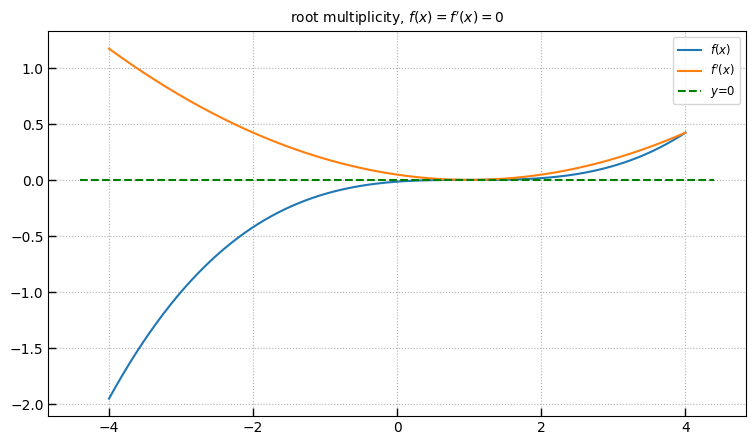

In [44]:
plot_func(mult_func, mult_deriv, title=r'root multiplicity, $f(x) = f^\prime(x) = 0$')

# Newton convergence for multiple roots

(in notebook)

In [45]:
# Newton algorithm with new function
a0 = -1.1
mult_power = 2; myfunc = mult_func; myfunc_deriv = mult_deriv
show(newton_app, **show_kws)

In [46]:
# Newton algorithm with new function
mult_power = 3; myfunc = mult_func; myfunc_deriv = mult_deriv
show(newton_app, notebook_handle=True)

In [47]:
# Compare bisector
a0, b0 = -1.1, 2.0
mult_power = 3; myfunc = mult_func; myfunc_deriv = mult_deriv
show(bisect_app, **show_kws)

In [47]:
# Compare inverse quadratic
show(inverse_quad_app, **show_kws)

In [48]:
# Print and compare iterations
from scipy.optimize import brentq

mult_power = 3; myfunc = mult_func; myfunc_deriv = mult_deriv

a0, b0 = -1.1, 0.8; myfunc = orig_func; myfunc_deriv = orig_deriv

a0, b0 = -1.85, 3.0; myfunc = saddle_func; myfunc_deriv = saddle_deriv
# a0, b0 = -1.0, 3.0; myfunc = saddle_func; myfunc_deriv = saddle_deriv

print(f'{"i":>3}    bisect   invquad     brent   newton')
print('-'*50)

for i in range(1, 20):
    br = brentq(myfunc, a0, b0, maxiter=i, disp=False)
    ai, bi, _ = bisection_root(myfunc, a0, b0, n_steps=i)
    am = (ai + (bi-ai)/2.)

    bq, _, _ = inverse_quad_root(myfunc, a0, b0, n_steps=i)
    
    if i < 2000:
        _ = newton_root(myfunc, myfunc_deriv, a0, n_steps=i)
    else:
        _ = newton_root(myfunc, myfunc_deriv, am, n_steps=i)
        
    print(f'{i:>3}  {am:8.5f}  {bq:8.5f}  {br:8.5f}   {_[0]:8.5f}')

  i    bisect   invquad     brent   newton
--------------------------------------------------
  1   1.78750   3.22719   0.93379   -1.85000
  2   2.39375   3.49725   1.87954    0.01332
  3   2.09062   1.88313   2.57703   24052.68858
  4   2.24219   2.26077   2.28974   16035.12572
  5   2.31797   2.34919   2.33445   10690.08381
  6   2.35586   2.33935   2.33923   7126.72254
  7   2.33691   2.33921   2.33921   4751.14836
  8   2.34639   2.33921   2.33921   3167.43224
  9   2.34165   2.33921   2.33921   2111.62149
 10   2.33928   2.33921   2.33921   1407.74766
 11   2.33810   2.33921   2.33921   938.49844
 12   2.33869   2.33921   2.33921   625.66563
 13   2.33899   2.33921   2.33921   417.11043
 14   2.33913   2.33921   2.33921   278.07365
 15   2.33921   2.33921   2.33921   185.38249
 16   2.33925   2.33921   2.33921   123.58845
 17   2.33923   2.33921   2.33921   82.39258
 18   2.33922   2.33921   2.33921   54.92901
 19   2.33921   2.33921   2.33921   36.62076


In [49]:
# multiplicity = 4
mult_power = 4; myfunc = mult_func; myfunc_deriv = mult_deriv
show(newton_app, **show_kws)

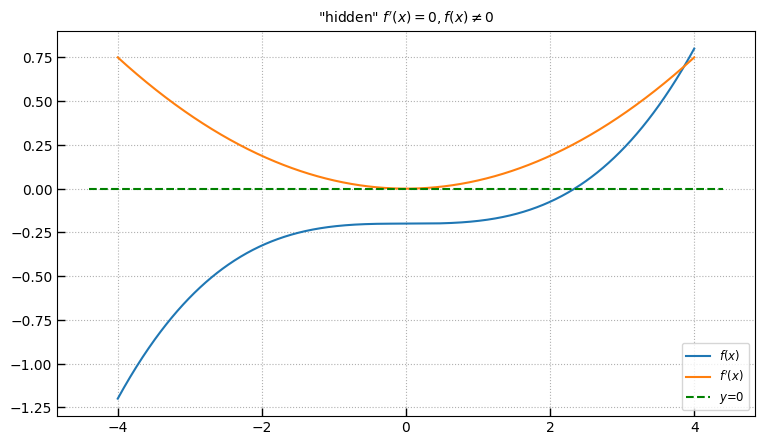

In [50]:
plot_func(saddle_func, saddle_deriv, title=r'"hidden" $f^\prime(x) = 0, f(x) \neq 0$')

In [51]:
a0 = -1.85
myfunc = saddle_func; myfunc_deriv = saddle_deriv
show(newton_app, **show_kws)

In [52]:
# Compare secant
show(secant_app, **show_kws)

In [53]:
# Compare bisector
a0, b0 = -1.85, 2.5
show(bisect_app,  **show_kws)

ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://127.0.0.1:8000';                       use --allow-websocket-origin=127.0.0.1:8000 or set BOKEH_ALLOW_WS_ORIGIN=127.0.0.1:8000 to permit this; currently we allow origins {'localhost:8889'}
ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://127.0.0.1:8000';                       use --allow-websocket-origin=127.0.0.1:8000 or set BOKEH_ALLOW_WS_ORIGIN=127.0.0.1:8000 to permit this; currently we allow origins {'localhost:8889'}
ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://127.0.0.1:8000';                       use --allow-websocket-origin=127.0.0.1:8000 or set BOKEH_ALLOW_WS_ORIGIN=127.0.0.1:8000 to permit this; currently we allow origins {'localhost:8889'}
ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://127.0.0.1:8000';                       use --allow-websocket-origin=127.0.0.1:8000 or set BOKEH_ALLOW_WS_ORIGIN=127.0.0.1

In [55]:
show(inverse_quad_app, **show_kws)

# Conclusions

- For something as simple as solvers in 1D there are many approaches
- Convergence rate is important for performance
   - But the number of function evaluations is also a factor
- If you know a narrow bracket the simple methods are quite efficient
  - (If your function is well behaved)
- Use more advanced methods if you don’t know where to look • or if your function is ill behaved

# Conclusions

**From "Numerical Recipes in C" (William H Press et al., 1992):**

> It cannot be overemphasized, however, how crucially success depends on having a good first guess for the solution, especially for multidimensional problems. This crucial beginning usually depends on analysis rather than numerics. Carefully crafted initial estimates reward you not only with reduced computational effort, but also with understanding and increased self-esteem.

*“This talk of insight is all very well, but what do I actually do?”*

# Conclusions

(Press, 1992, continued)

For one-dimensional root finding, it is possible to give some straightforward answers: You should try to **get some idea of what your function looks like before trying to find its roots**.

If you need to mass-produce roots for many different functions, then you should at least **know what some typical members of the ensemble look like**. 

Next, **you should always bracket a root**, that is, know that the function changes sign in an identified interval, before trying to converge to the root’s value.

> Brent’s algorithm is the method of choice to find a bracketed root of a general one-dimensional function, when you cannot easily compute the function’s derivative

### (testing) Javascript functions for standalone bokeh

In [181]:

# Javascript versions of the function definition and bisect algorithm

func_js = """
function myfunc(x) {
  return Math.pow(x, 2) - 4 * Math.sin(x);
}

function myfunc_deriv(x) {
  return 2 * x - 4 * Math.cos(x);
}
"""

bisect_js = """

function bisection_root(a, b, n_steps) {
  /*
  Do iterations of the bisection method to find roots
  */
  var fa, fb, fm, i, m;
  
  fa = myfunc(a);
  fb = myfunc(b);

  i = 0;

  for (var i = 0, _pj_a = n_steps; i < _pj_a; i += 1) {
    m = a + (b - a) / 2.0;
    fm = myfunc(m);

    if (Math.sign(fm) === Math.sign(fa)) {
      [a, fa] = [m, fm];
    } else {
      [b, fb] = [m, fm];
    }
  }

  return [a, b, i];
}
"""


if False:
    
    # Make a bokeh "app" for interactive plotting    
    from bokeh.models.callbacks import CustomJS
    from bokeh.events import DocumentReady
    
    def text_label(a, b):
        return f'a={a:7.4f} b={b:7.4f}  m={a + (b-a)/2.:11.8f}'
    
    fig = figure(title="bisection", width=800, height=600,
                 background_fill_color='white',
                 active_drag='box_zoom')
    
    fig.xaxis.axis_label = 'x'
    fig.yaxis.axis_label = 'y'
    fig.xaxis.axis_label_text_font_style = "normal"
    fig.yaxis.axis_label_text_font_style = "normal"
    
    data_line = fig.line(x=x, y=myfunc(x), color='black', alpha=0.5, line_width=2)
    
    init_source = {'x':[0,0], 'y': [0,0]}
    init_scatter = fig.scatter(source=init_source, size=10, color='black')
    # step_scatter = fig.scatter([0,0], [0,0], size=10, color='red', alpha=0.8)
    
    spans_source = {'x': [0,0]}
    
    spans = fig.vspan(source=spans_source, line_color='red', line_alpha=0.5)
    yroot = fig.hspan(y=[0], line_color='green', line_alpha=0.3)
    
    midp_source = {'x': [0]}
    midp_vline = fig.vspan(source=midp_source, line_color='magenta', line_alpha=0.5)
    
    ITEM_HEIGHT = 64
    text_a = TextInput(title='a', value=f'{a0:.2f}', width=70, height=ITEM_HEIGHT)
    text_b = TextInput(title='b', value=f'{b0:.2f}', width=70, height=ITEM_HEIGHT)
    
    txt = Div(text=text_label(a0, b0), sizing_mode="fixed", width=500, height=ITEM_HEIGHT,
              styles={'font-size': '150%', 'font-family': 'monospace'})
    
    nsteps = Slider(start=0, end=20, value=0, step=1, 
                    title='n_steps', sizing_mode="fixed", width=300, height=ITEM_HEIGHT)
    
    active_objects = dict(nsteps=nsteps,
                          init_scatter=init_scatter,
                          spans=spans,
                          midp_vline=midp_vline,
                          text_a=text_a, text_b=text_b,
                          txt=txt,
                         )
    
    callback = CustomJS(args=active_objects, code=f"""
    
    {func_js}
    
    {bisect_js}
    
    // JavaScript code goes here
    
    // the model that triggered the callback is cb_obj:
    var n_step = parseInt(nsteps.value);
    
    var res = bisection_root(parseFloat(text_a.value), parseFloat(text_b.value), n_step);
    var ai = res[0];
    var bi = res[1]
    
    spans.data_source.data['x'] = [ai, bi];
    var m = ai + (bi-ai)/2;
    midp_vline.data_source.data['x'] = [m];
    
    spans.data_source.change.emit();
    midp_vline.data_source.change.emit();
    
    txt.text = 'a=' + ai.toFixed(4) + ', b=' + bi.toFixed(4) + ', m=' + m.toFixed(8); 
    txt.text.change.emit();
    
    """)
    
    if 0:
        def update_steps():
            """
            Perform n steps of the bisection algorithm and then plot the results
            """
            n_step = nsteps.value
            a0i = float(text_a.value)
            b0i = float(text_b.value)
        
            init_scatter.data_source.data = {'x': [a0i, b0i], 'y': myfunc([a0i, b0i])}
        
            ai, bi, i = bisection_root(myfunc, a0i, b0i, n_steps=n_step, tol=None)
            # step_scatter.data_source.data = {'x': [ai, bi], 'y': myfunc([ai, bi])}
            spans.data_source.data = {'x': [ai, bi]}
            
            m = ai + (bi-ai)/2        
            midp_vline.data_source.data = {'x': [m]}
        
            txt.text = text_label(ai, bi)
    
    # update_steps()
    
    nsteps.js_on_change('value', callback)
    text_a.js_on_change('value', callback)
    text_b.js_on_change('value', callback)
    
    sliders = row(nsteps)
    p = layout([[text_a, text_b, sliders, txt],
                [fig]])
    
    curdoc().js_on_event(DocumentReady, callback)

    # Show bisector widget
    show(p, notebook_handle=True)